In [1]:
import numpy as np
import torch
from data.synthetic_dataset import * #create_synthetic_dataset, SyntheticDataset , ECG5000Dataset,load_ECG5000
from models.seq2seq import EncoderRNN, DecoderRNN, Net_GRU
from loss.dilate_loss import dilate_loss
from torch.utils.data import DataLoader
import random
from tslearn.metrics import dtw, dtw_path
import matplotlib.pyplot as plt
import warnings
import warnings; warnings.simplefilter('ignore')


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
# random.seed(0)

# parameters
batch_size = 100
N_input = 90
N_output = 62 
sigma = 0.01
gamma = 0.01

# Load synthetic dataset
# X_train_input,X_train_target,X_test_input,X_test_target,train_bkp,test_bkp = create_synthetic_dataset(N,N_input,N_output,sigma)
# dataset_train = SyntheticDataset(X_train_input,X_train_target, train_bkp)
# dataset_test  = SyntheticDataset(X_test_input,X_test_target, test_bkp)
# trainloader = DataLoader(dataset_train, batch_size=batch_size,shuffle=True, num_workers=1)
# testloader  = DataLoader(dataset_test, batch_size=batch_size,shuffle=False, num_workers=1)


# Load ECG dataset
filepath_train = '/cvlabdata2/cvlab/datasets_yiwang/Wafer_TRAIN.txt'
filepath_test = '/cvlabdata2/cvlab/datasets_yiwang/Wafer_TEST.txt'
x_train_ip, x_train_op, x_test_ip, x_test_op, train_bkp, test_bkp = load_wafer(filepath_train, filepath_test)
# print (x_train_ip.shape, x_train_op.shape, x_test_ip.shape, x_test_op.shape)
dataset_train = ECG5000Dataset(x_train_ip, x_train_op, train_bkp)
dataset_test  = ECG5000Dataset(x_test_ip, x_test_op, test_bkp)
trainloader = DataLoader(dataset_train, batch_size=batch_size,shuffle=True, num_workers=1)
testloader  = DataLoader(dataset_test, batch_size=batch_size,shuffle=False, num_workers=1)


# # Traffic Analysis

# N_input = 168
# N_output = 24
# loc = '/cvlabdata2/cvlab/datasets_yiwang/traffic.txt'
# # Load Min Temp dataset
# x_train_ip, x_train_op, x_test_ip, x_test_op, train_bkp, test_bkp = load_traffic(loc)
# # print (x_train_ip.shape, x_train_op.shape, x_test_ip.shape, x_test_op.shape)
# dataset_train = ECG5000Dataset(x_train_ip, x_train_op, train_bkp)
# dataset_test  = ECG5000Dataset(x_test_ip, x_test_op, test_bkp)
# trainloader = DataLoader(dataset_train, batch_size=batch_size,shuffle=True, num_workers=1)
# testloader  = DataLoader(dataset_test, batch_size=batch_size,shuffle=False, num_workers=1)




def train_model(net,loss_type, learning_rate, epochs=1000, gamma = 0.001,
                print_every=50,eval_every=50, verbose=1, Lambda=1, alpha=0.5):
    
    optimizer = torch.optim.Adam(net.parameters(),lr=learning_rate)
    criterion = torch.nn.MSELoss()
    
    for epoch in range(epochs): 
        for i, data in enumerate(trainloader, 0):
            inputs, target, _ = data
            inputs = torch.tensor(inputs, dtype=torch.float32).to(device)
            target = torch.tensor(target, dtype=torch.float32).to(device)
            batch_size, N_output = target.shape[0:2]                     

            # forward + backward + optimize
            outputs = net(inputs)
            loss_mse,loss_shape,loss_temporal = torch.tensor(0),torch.tensor(0),torch.tensor(0)
            
            if (loss_type=='mse'):
                loss_mse = criterion(target,outputs)
                loss = loss_mse                   
 
            if (loss_type=='dilate'):    
                loss, loss_shape, loss_temporal = dilate_loss(target,outputs,alpha, gamma, device)     
            
            if (loss_type=='dilate_shape'):    
                loss, loss_shape, loss_temporal = dilate_loss(target,outputs,alpha, gamma, device)     
                loss = loss_shape
                
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()          
        
        if(verbose):
            if (epoch % print_every == 0):
                print('epoch ', epoch, ' loss ',loss.item(),' loss shape ',loss_shape.item(),' loss temporal ',loss_temporal.item())
                eval_model(net,testloader, gamma,verbose=1)
  

 
def eval_model(net,loader, gamma,verbose=1):   
    criterion = torch.nn.MSELoss()
    losses_mse = []
    losses_dtw = []
    losses_tdi = []   

    for i, data in enumerate(loader, 0):
        loss_mse, loss_dtw, loss_tdi = torch.tensor(0),torch.tensor(0),torch.tensor(0)
        # get the inputs
        inputs, target, breakpoints = data
        inputs = torch.tensor(inputs, dtype=torch.float32).to(device)
        target = torch.tensor(target, dtype=torch.float32).to(device)
        batch_size, N_output = target.shape[0:2]
        outputs = net(inputs)
         
        # MSE    
        loss_mse = criterion(target,outputs)    
        loss_dtw, loss_tdi = 0,0
        # DTW and TDI
        for k in range(batch_size):         
            target_k_cpu = target[k,:,0:1].view(-1).detach().cpu().numpy()
            output_k_cpu = outputs[k,:,0:1].view(-1).detach().cpu().numpy()

            loss_dtw += dtw(target_k_cpu,output_k_cpu)
            path, sim = dtw_path(target_k_cpu, output_k_cpu)   
                       
            Dist = 0
            for i,j in path:
                    Dist += (i-j)*(i-j)
            loss_tdi += Dist / (N_output*N_output)            
                        
        loss_dtw = loss_dtw /batch_size
        loss_tdi = loss_tdi / batch_size

        # print statistics
        losses_mse.append( loss_mse.item() )
        losses_dtw.append( loss_dtw )
        losses_tdi.append( loss_tdi )

    print( ' Eval mse= ', np.array(losses_mse).mean() ,' dtw= ',np.array(losses_dtw).mean() ,' tdi= ', np.array(losses_tdi).mean()) 


encoder = EncoderRNN(input_size=1, hidden_size=128, num_grulstm_layers=1, batch_size=batch_size).to(device)
decoder = DecoderRNN(input_size=1, hidden_size=128, num_grulstm_layers=1,fc_units=16, output_size=1).to(device)
net_gru_dilate = Net_GRU(encoder,decoder, N_output, device).to(device)
train_model(net_gru_dilate,loss_type='dilate',learning_rate=0.001, epochs=1000, gamma=gamma, print_every=50, eval_every=50,verbose=1)

encoder = EncoderRNN(input_size=1, hidden_size=128, num_grulstm_layers=1, batch_size=batch_size).to(device)
decoder = DecoderRNN(input_size=1, hidden_size=128, num_grulstm_layers=1,fc_units=16, output_size=1).to(device)
net_gru_mse = Net_GRU(encoder,decoder, N_output, device).to(device)
train_model(net_gru_mse,loss_type='mse',learning_rate=0.001, epochs=1000, gamma=gamma, print_every=50, eval_every=50,verbose=1)

encoder = EncoderRNN(input_size=1, hidden_size=128, num_grulstm_layers=1, batch_size=batch_size).to(device)
decoder = DecoderRNN(input_size=1, hidden_size=128, num_grulstm_layers=1,fc_units=16, output_size=1).to(device)
net_gru_dilate_shape = Net_GRU(encoder,decoder, N_output, device).to(device)
train_model(net_gru_dilate_shape,loss_type='dilate_shape',learning_rate=0.001, epochs=1000, gamma=gamma, print_every=50, eval_every=50,verbose=1)



epoch  0  loss  23.69552993774414  loss shape  47.15834426879883  loss temporal  0.23271726071834564
 Eval mse=  0.7831362595160802  dtw=  6.813241167324424  tdi=  0.507633064516129
epoch  50  loss  1.977982759475708  loss shape  2.293534994125366  loss temporal  1.6624305248260498
 Eval mse=  0.42582999368508656  dtw=  1.5736692287623872  tdi=  2.368846427332639
epoch  100  loss  0.8948144912719727  loss shape  0.32543322443962097  loss temporal  1.464195728302002
 Eval mse=  0.5513559401035308  dtw=  1.0392281451865115  tdi=  2.2080612209503987
epoch  150  loss  1.1634875535964966  loss shape  0.23886507749557495  loss temporal  2.0881099700927734
 Eval mse=  0.6876849869887034  dtw=  0.9294090926935481  tdi=  2.5609458896982313
epoch  200  loss  0.9244597554206848  loss shape  0.43945929408073425  loss temporal  1.409460186958313
 Eval mse=  0.4944350967804591  dtw=  0.9637246416590375  tdi=  2.3063488120013873
epoch  250  loss  1.0397346019744873  loss shape  0.038003187626600266  

 Eval mse=  1.5140337844689686  dtw=  0.5163170832494509  tdi=  9.027406130766561
epoch  400  loss  -0.48640355467796326  loss shape  -0.48640355467796326  loss temporal  9.040863037109375
 Eval mse=  1.5235166251659393  dtw=  0.4267362857361782  tdi=  9.114521765522026
epoch  450  loss  -0.6106835603713989  loss shape  -0.6106835603713989  loss temporal  10.311299324035645
 Eval mse=  1.5232919255892436  dtw=  0.39462009007788407  tdi=  8.832698838015954
epoch  500  loss  -0.4566851556301117  loss shape  -0.4566851556301117  loss temporal  9.271346092224121
 Eval mse=  1.554357099533081  dtw=  0.38926201093479107  tdi=  8.992380809920222
epoch  550  loss  -0.5974506139755249  loss shape  -0.5974506139755249  loss temporal  9.586397171020508
 Eval mse=  1.5365257958571117  dtw=  0.35202096065647964  tdi=  8.796892646548734
epoch  600  loss  -0.5518971085548401  loss shape  -0.5518971085548401  loss temporal  9.591445922851562
 Eval mse=  1.5519687314828237  dtw=  0.3628481417634486  td

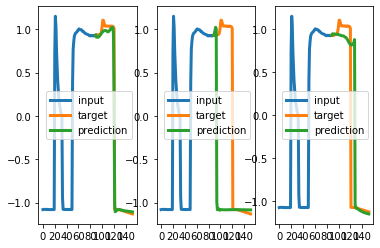

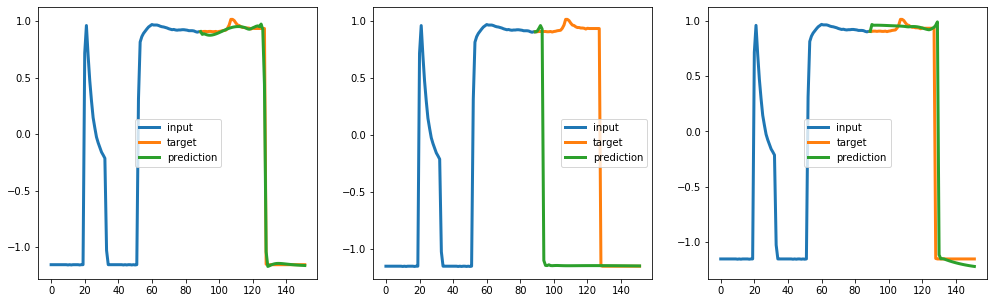

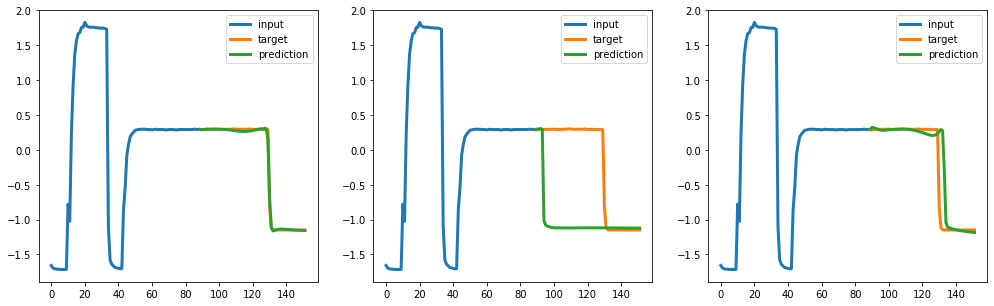

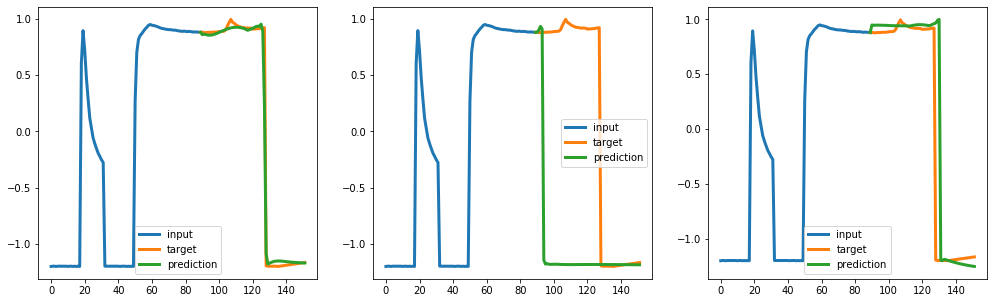

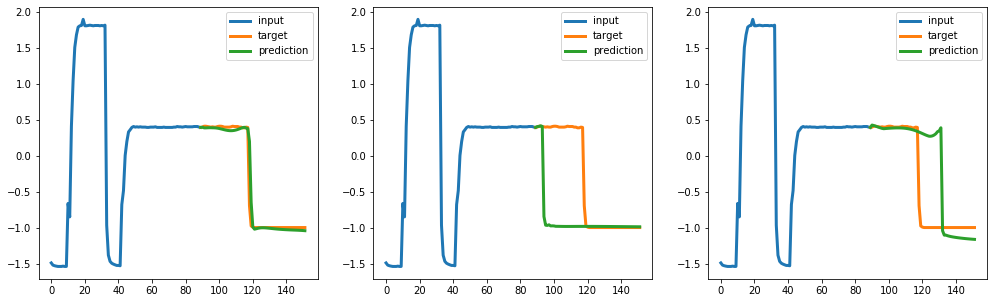

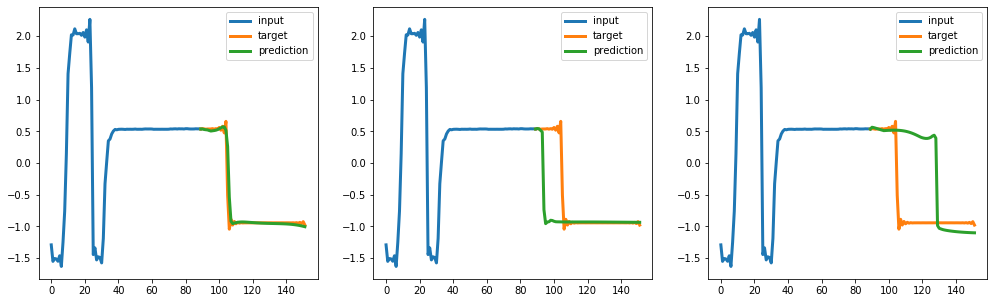

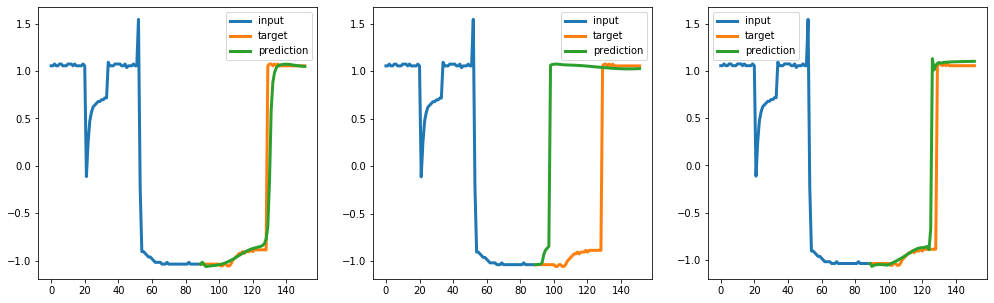

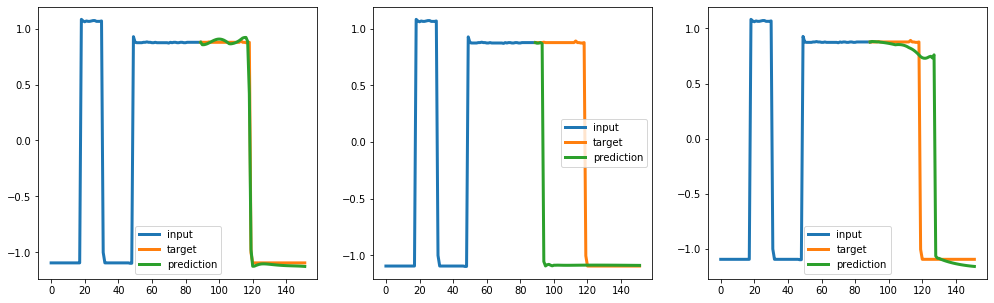

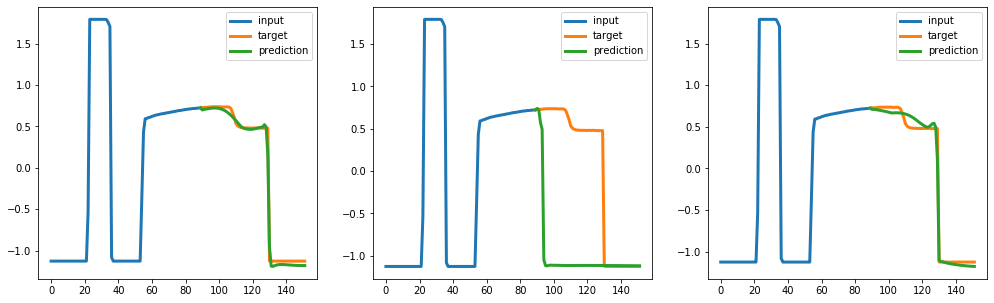

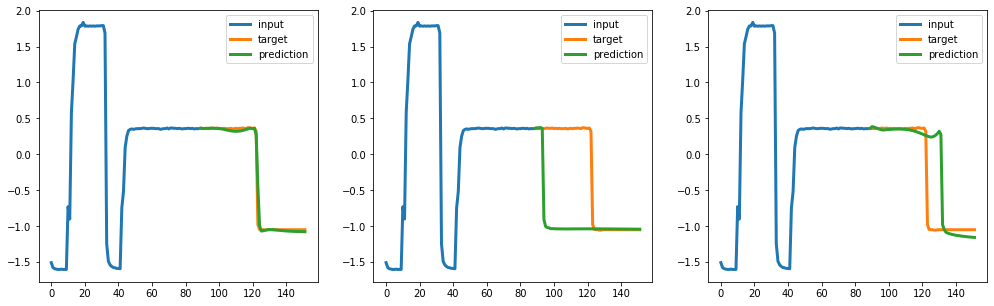

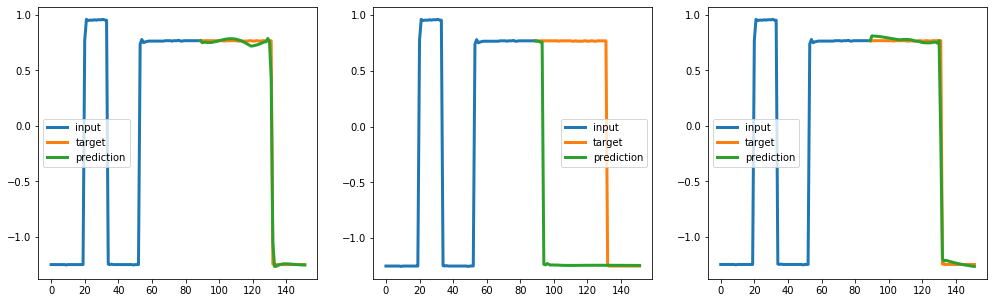

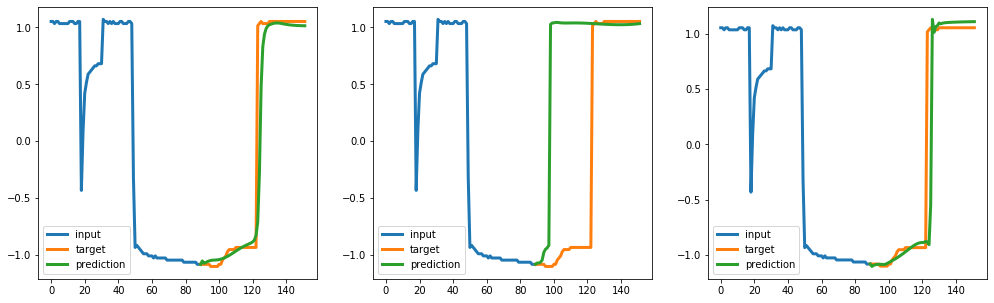

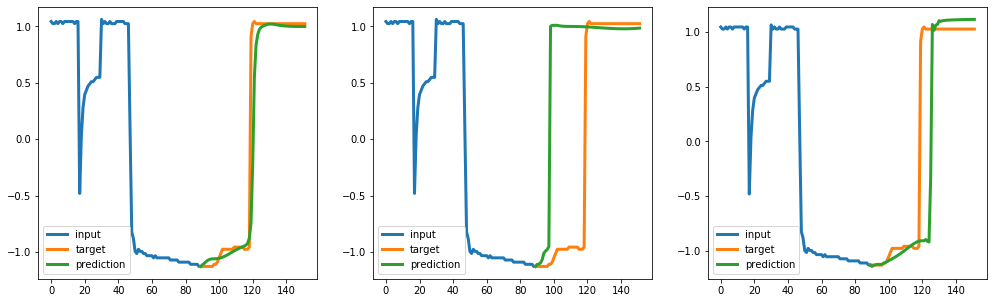

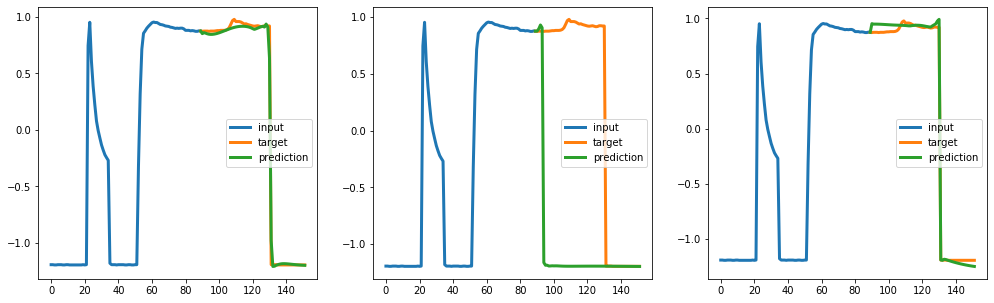

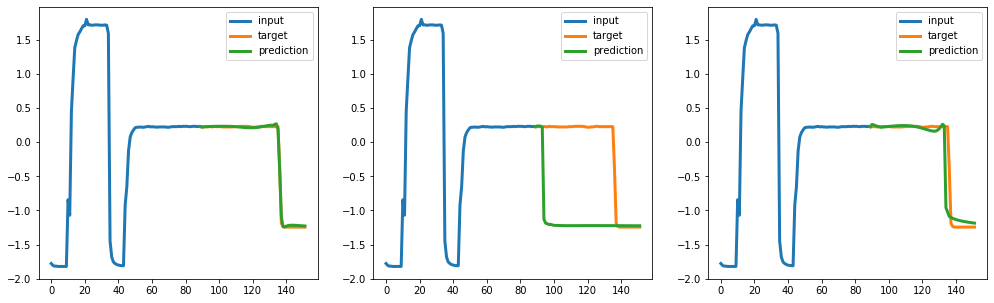

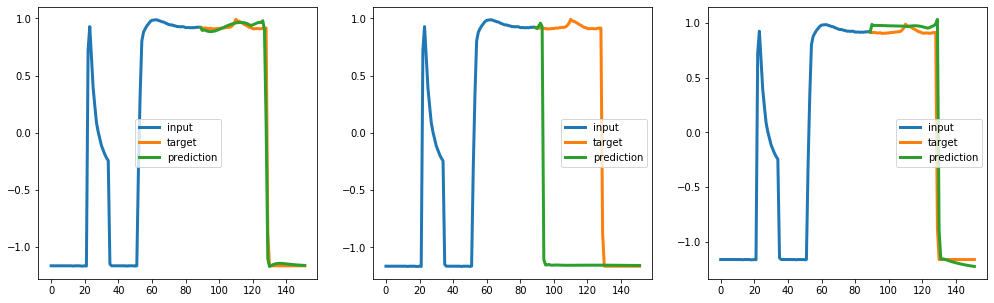

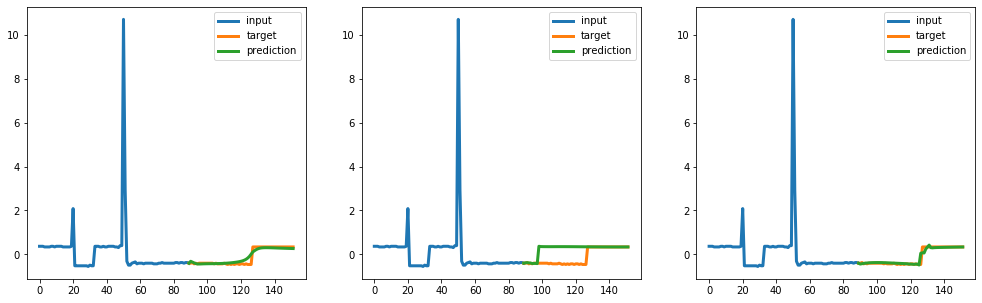

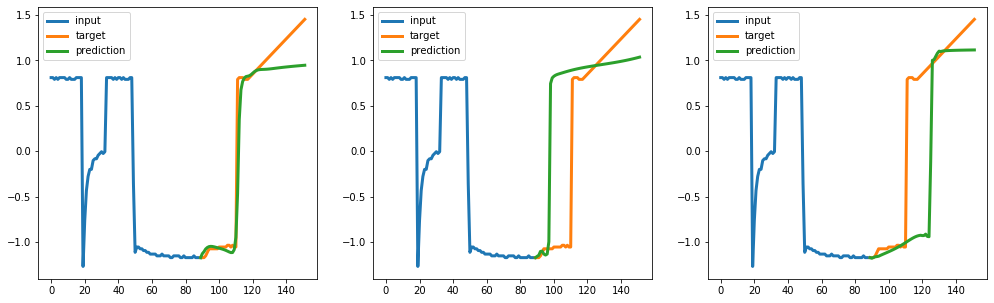

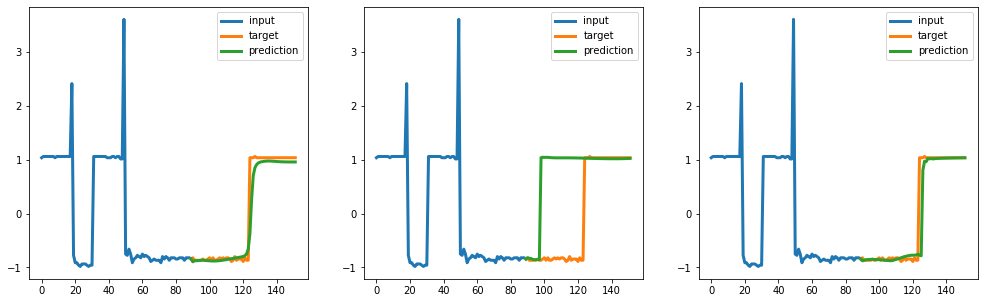

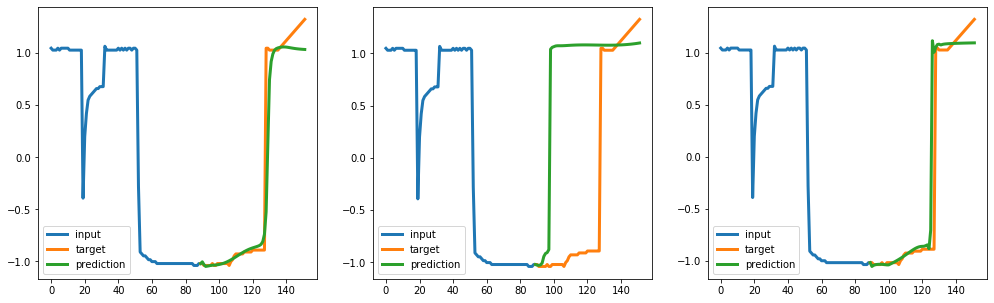

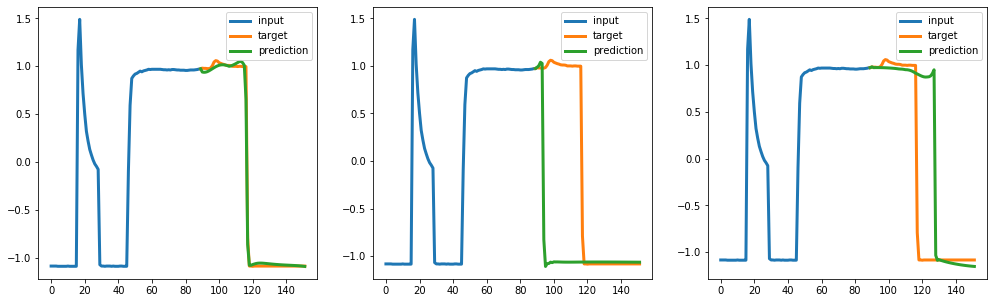

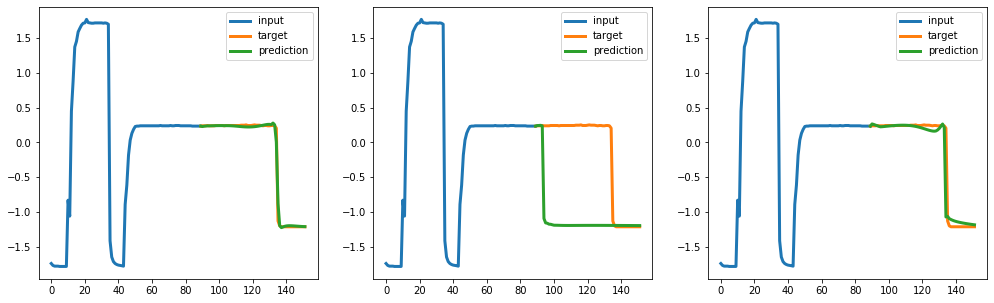

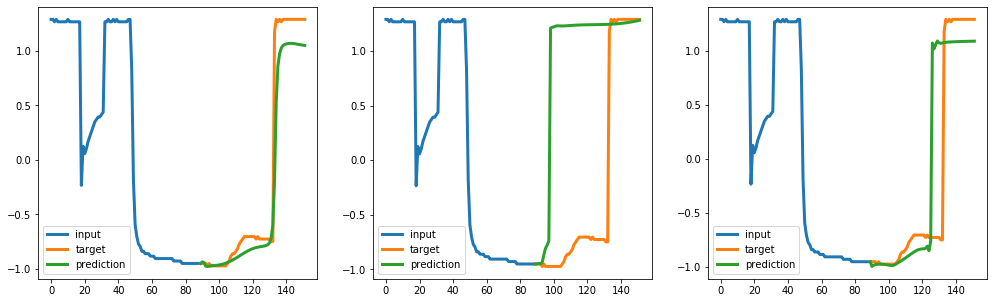

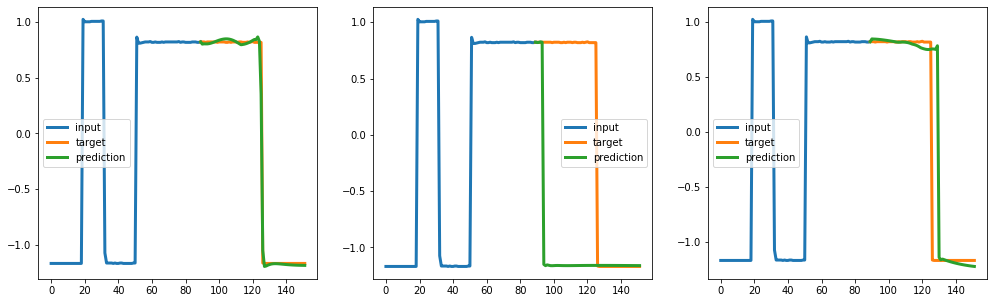

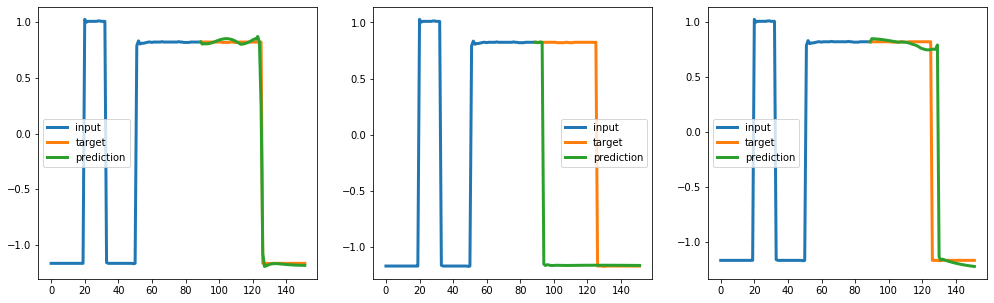

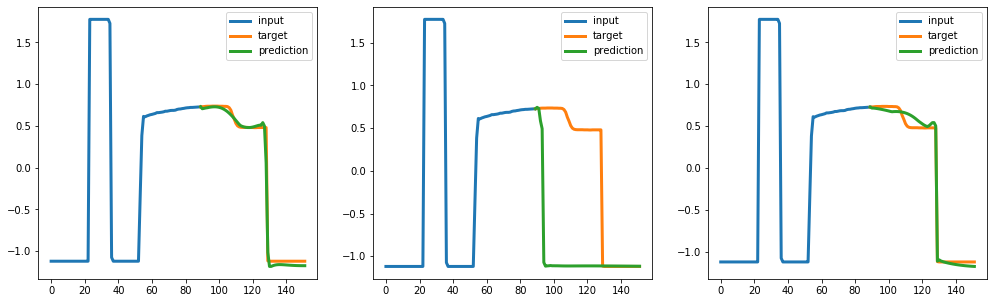

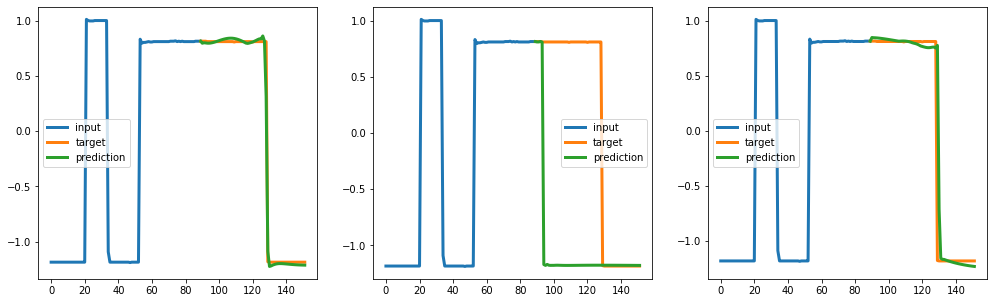

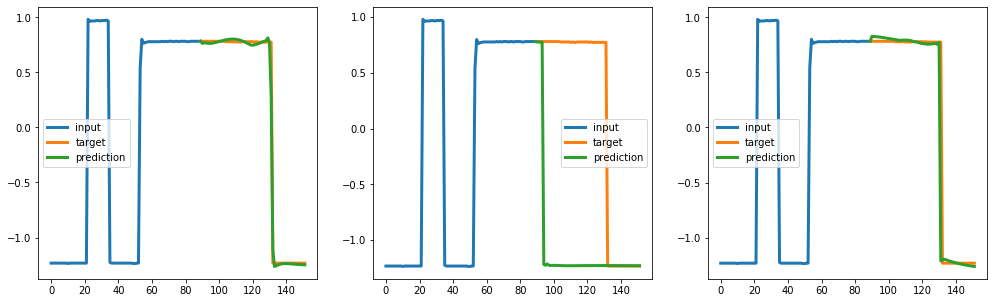

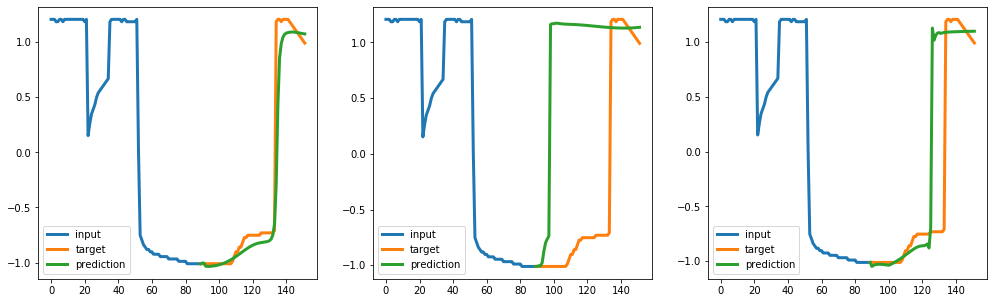

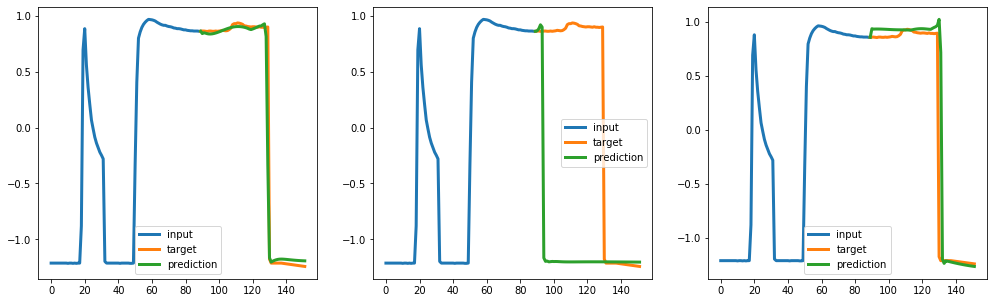

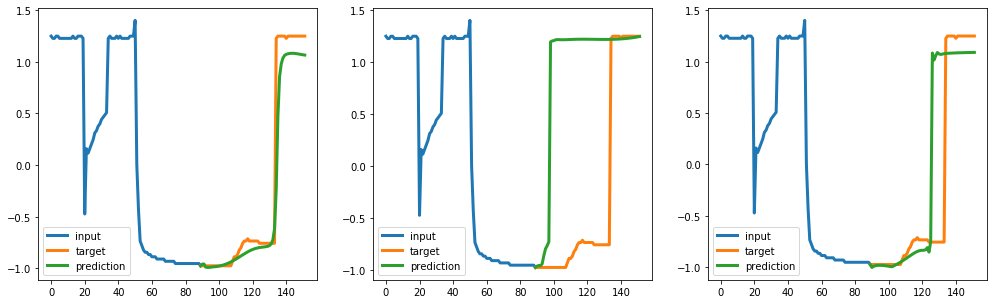

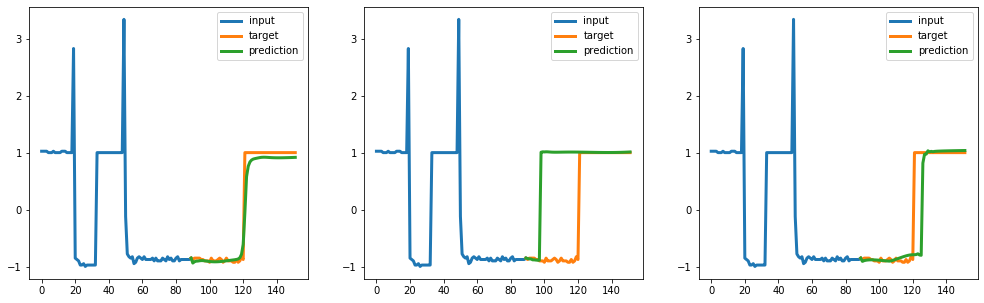

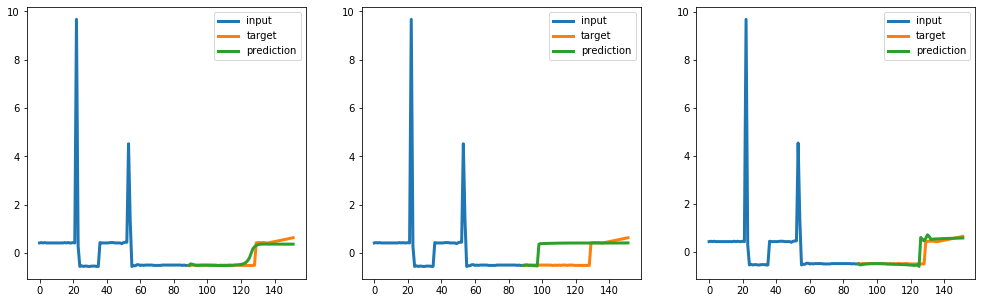

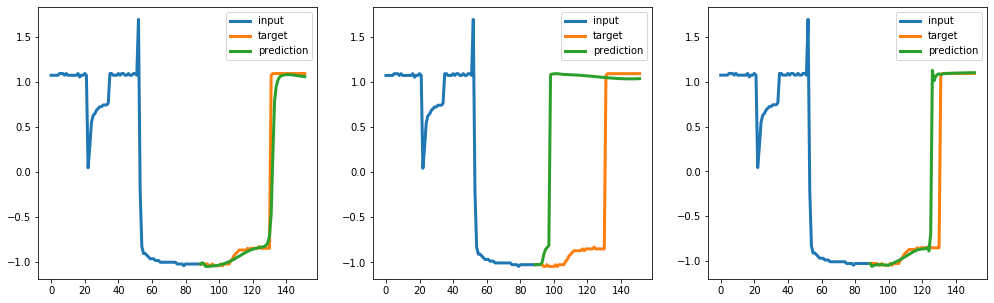

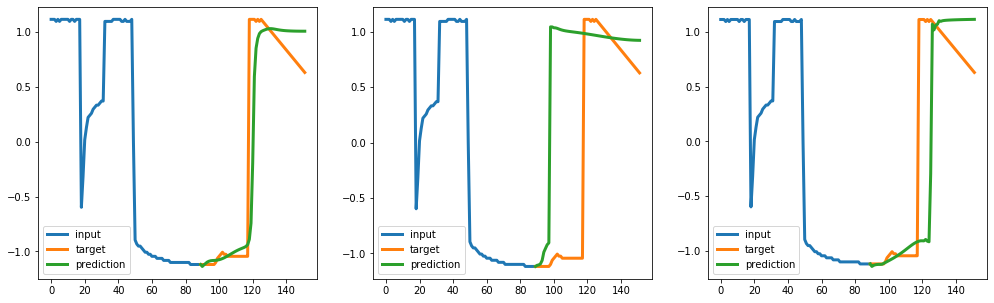

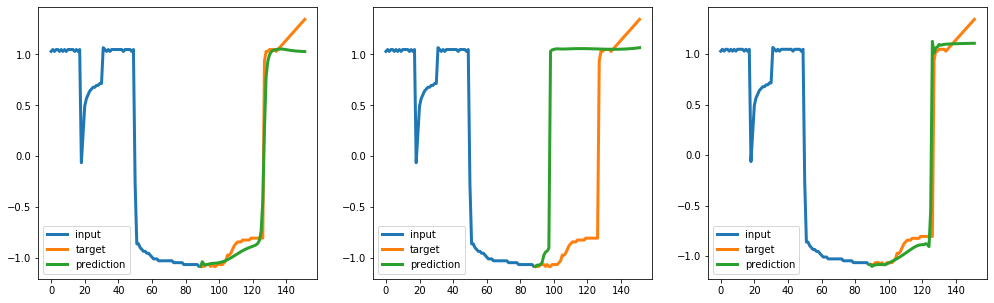

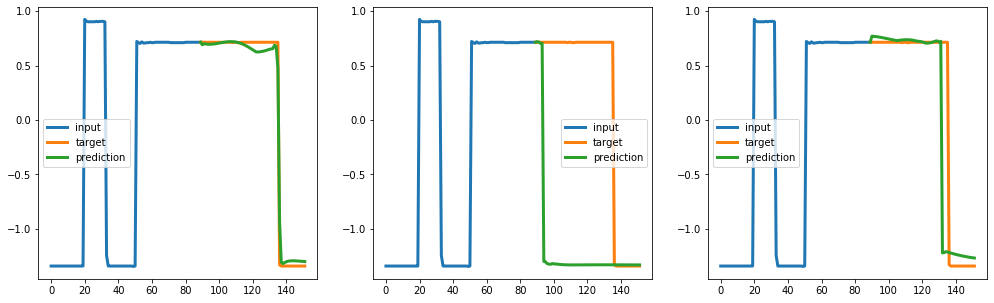

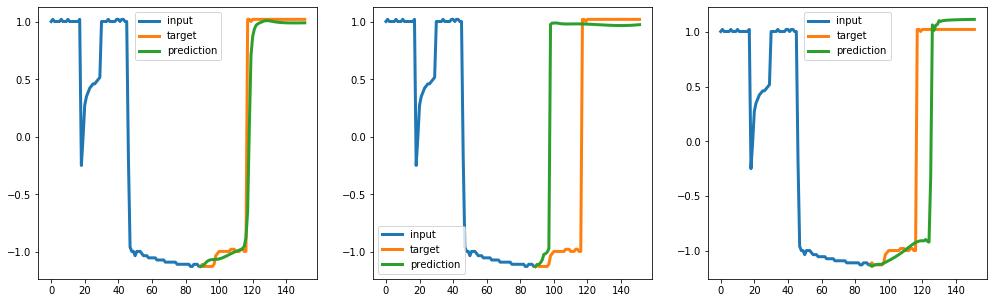

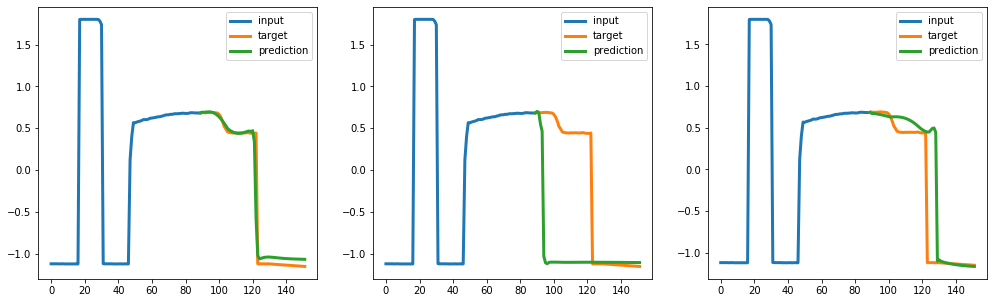

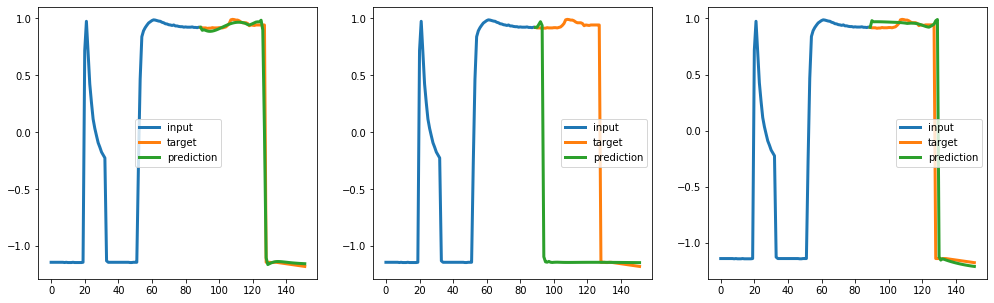

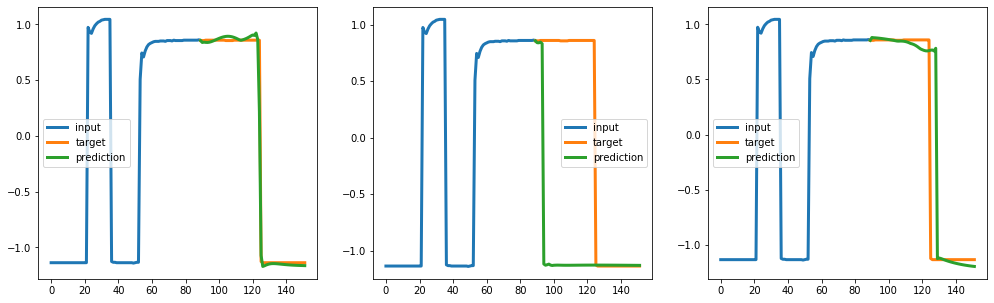

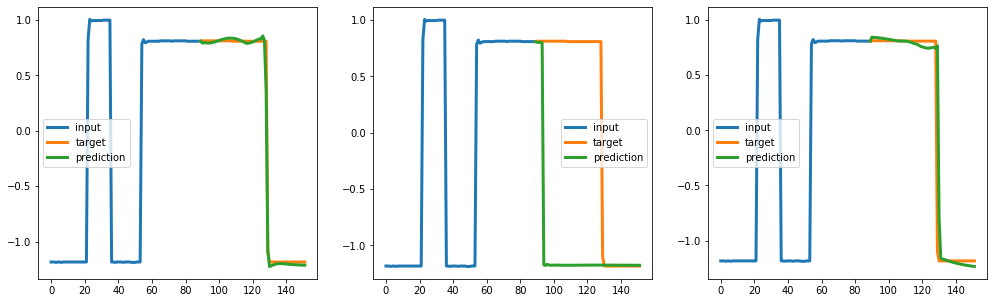

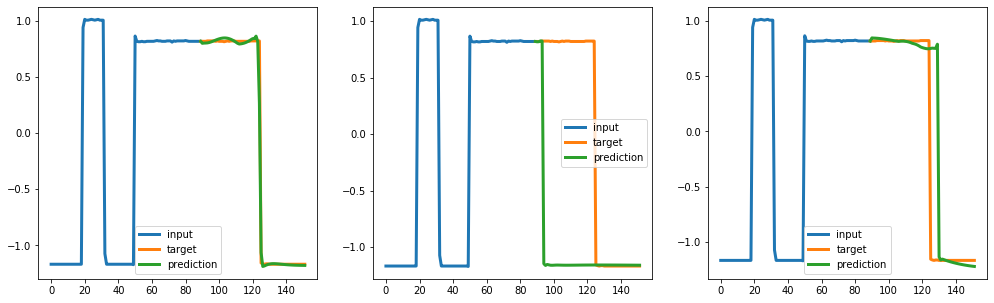

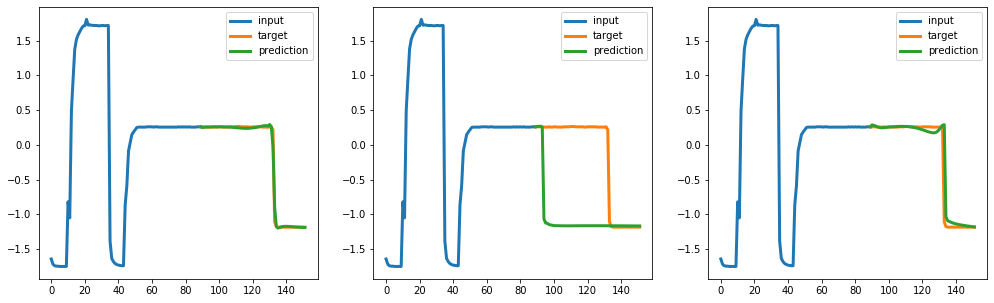

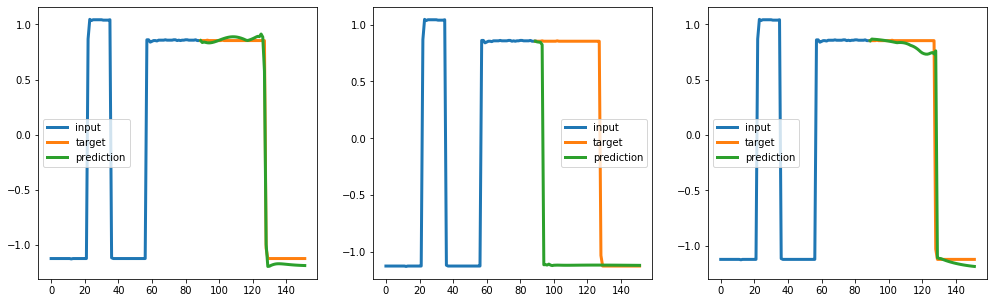

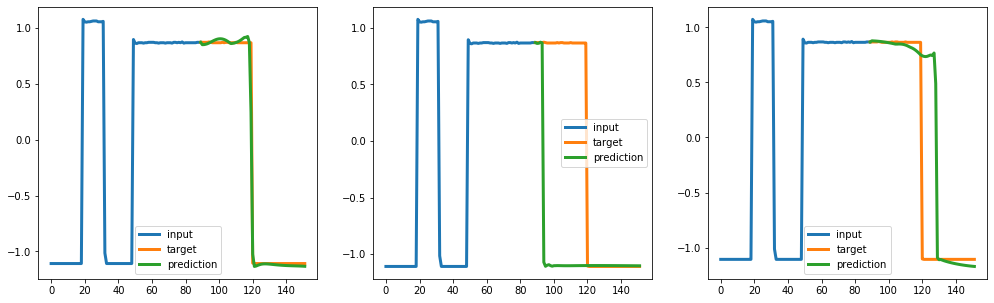

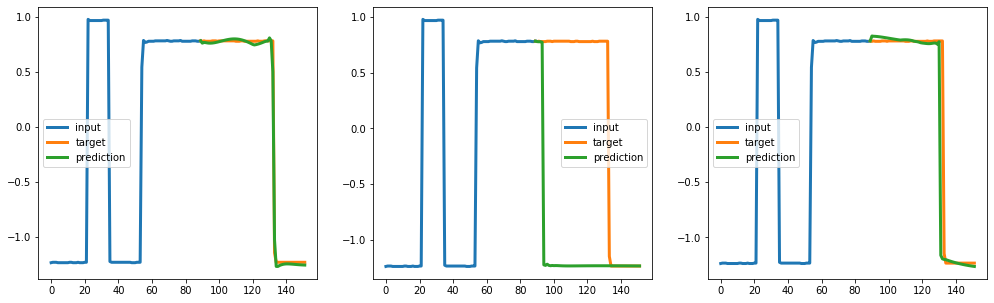

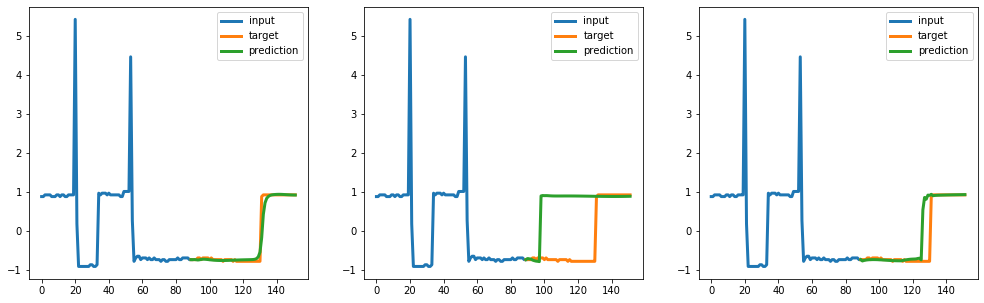

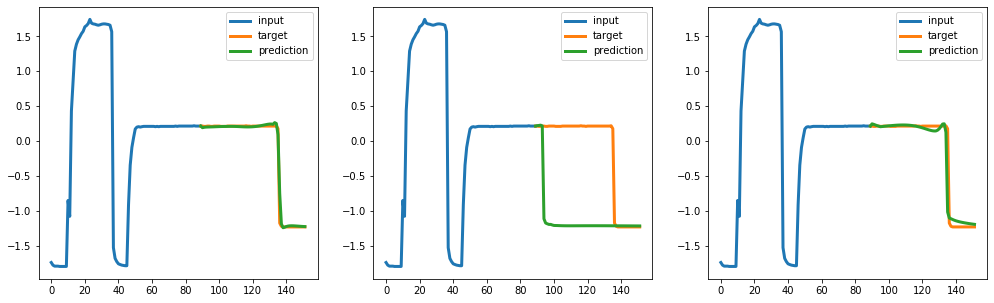

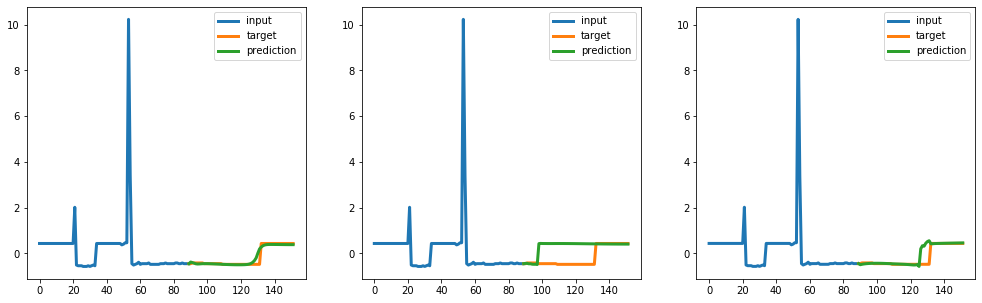

In [5]:
# Visualize results
gen_test = iter(testloader)
test_inputs, test_targets, breaks = next(gen_test)

test_inputs  = torch.tensor(test_inputs, dtype=torch.float32).to(device)
test_targets = torch.tensor(test_targets, dtype=torch.float32).to(device)
criterion = torch.nn.MSELoss()

nets = [net_gru_mse,net_gru_dilate_shape,net_gru_dilate]

for ind in range(1,51):
    plt.figure()
    plt.rcParams['figure.figsize'] = (17.0,5.0)  
    k = 1
    for net in nets:
        pred = net(test_inputs).to(device)

        input = test_inputs.detach().cpu().numpy()[ind,:,:]
        target = test_targets.detach().cpu().numpy()[ind,:,:]
        preds = pred.detach().cpu().numpy()[ind,:,:]

        plt.subplot(1,3,k)
        plt.plot(range(0,N_input) ,input,label='input',linewidth=3)
        plt.plot(range(N_input-1,N_input+N_output), np.concatenate([ input[N_input-1:N_input], target ]) ,label='target',linewidth=3)   
        plt.plot(range(N_input-1,N_input+N_output),  np.concatenate([ input[N_input-1:N_input], preds ])  ,label='prediction',linewidth=3)       
        plt.xticks(range(0,N_input+N_output,20))
        plt.legend()
        k = k+1

    plt.show()